In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = None
import xgboost
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\ronan\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## (1) Read in data

In [2]:
df_train = pd.read_csv('train.csv', index_col='Id')
y_train = df_train.SalePrice

## (2) Exploratory Data Analysis and Feature Selelction

        - High level overview 
        - Explore numerical features
        - Explore categorical features

###  High level overview of data

Have a quick look to verify numerical and categorical columns are casted correcty. Sometimes an error in a column can change the data type of that entire column

In [3]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We have 36 numerical features(plus 1 for the target variable)

In [4]:
df_train.select_dtypes(exclude='object')

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,0,8,2007,175000
1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,0,2,2010,210000
1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,0,2500,5,2010,266500


We have 43 categorical features

In [5]:
df_train.select_dtypes(include='object')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
5,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,Stone,TA,TA,CBlock,Gd,TA,No,ALQ,Rec,GasA,TA,Y,SBrkr,TA,Min1,TA,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,None,Ex,Gd,Stone,TA,Gd,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal


#### <span style="color:red"> Conclusion</span>
 <span style="color:red">Numerical and categorical features have been casted to their correct datatype</span>

###  Explore numerical features

Extract numerical features and drop target

In [6]:
numerical_features = df_train.select_dtypes(exclude='object').drop('SalePrice', axis=1).copy()

Lets have a look to see how each numerical feature corelates to the target variable SalePrice. This allows us to visually observe outliers in the numerical data.

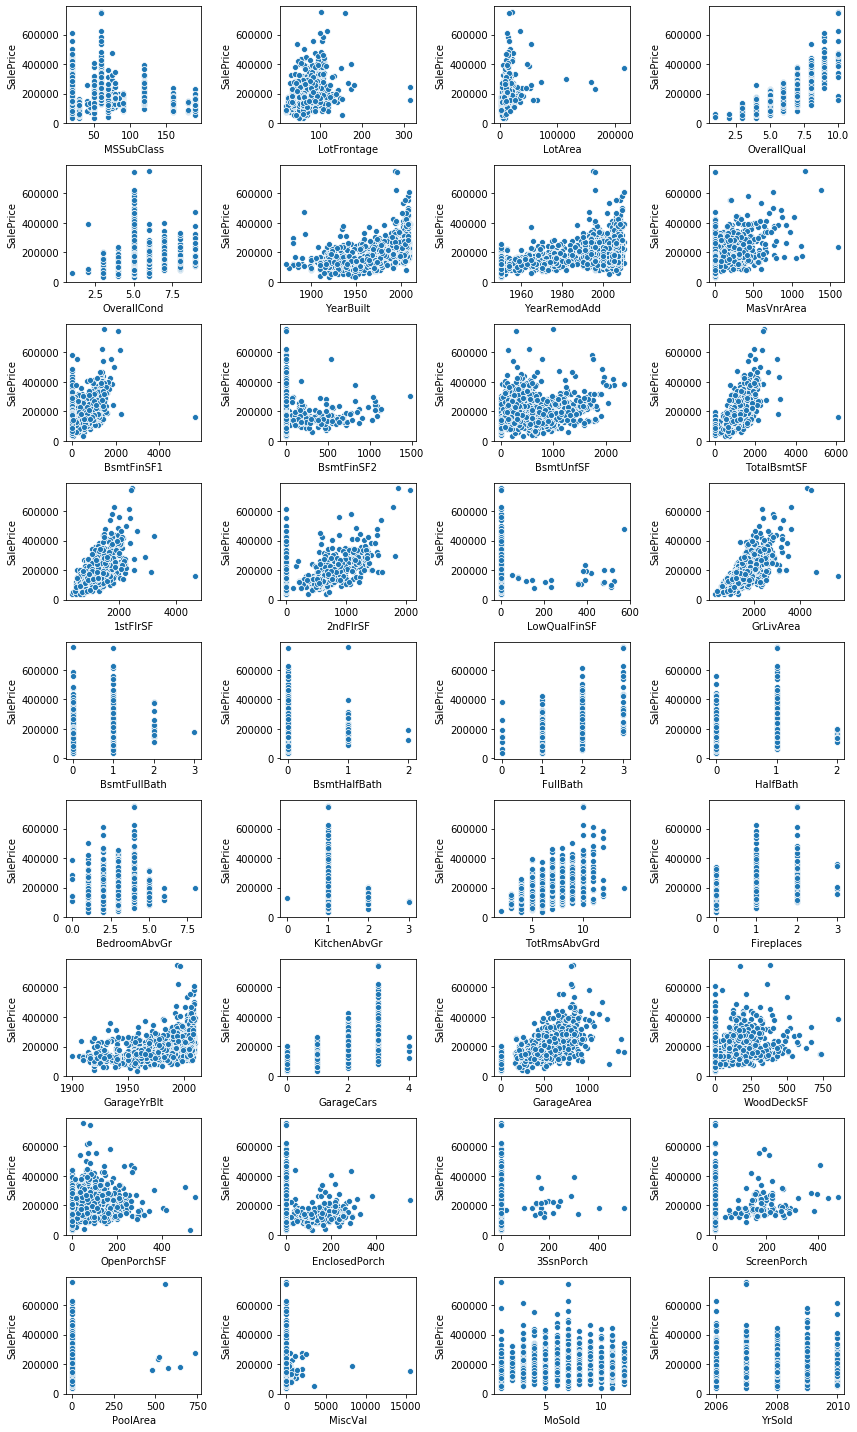

In [7]:
f = plt.figure(figsize=(12,20))

for i in range(len(numerical_features.columns)):
    f.add_subplot(9, 4, i+1)
    sns.scatterplot(numerical_features.iloc[:,i], y_train)
    
plt.tight_layout()
plt.show()

#### <span style="color:red"> Conclusion</span>
 <span style="color:red">Potential outliers to remove</span>
 <span style="color:red">LotFrontage > 200 , LotArea > 100,000 , BsmtFinSF1 > 3000, BsmtFinSF2 > 1300, TotalBsmtSF > 4000, 1stFlrSF > 4000 , GrLivArea > 4000 & SalePrice<30,000 , </span>

Correlation between features
 
Plotting a correlation matrix is a commonly used tool to discover linear relationships between any two numerical features.

If two features are highly correlated it is good practice to remove one on the features(The one least corelated to the target variable). Multicollinearity causes precision loss in our regression coefficients, affecting our ability to identify the most important features to our model.

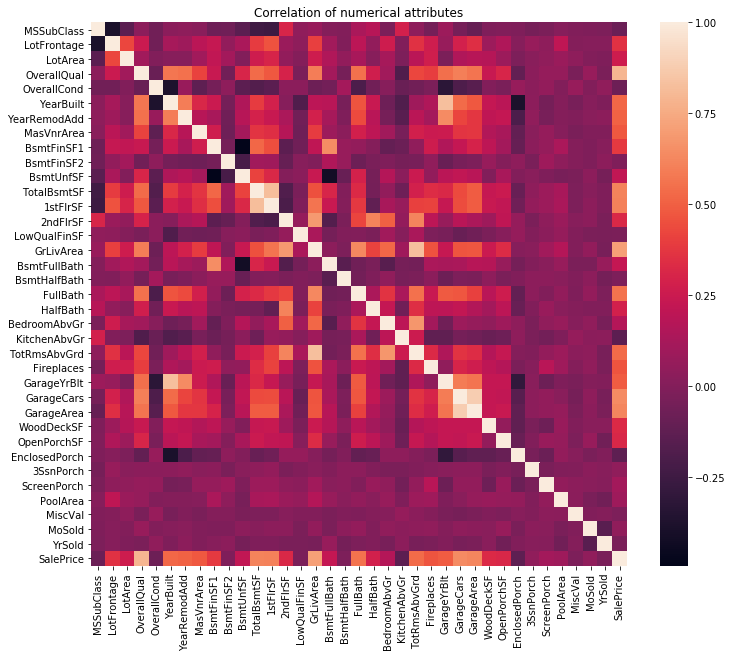

In [8]:
correlation = df_train.corr()

f, ax = plt.subplots(figsize=(12,10))
plt.title('Correlation of numerical attributes', size=12)
sns.heatmap(correlation)
plt.show()

In [9]:
correlation['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

#### <span style="color:red"> Conclusion</span>
 <span style="color:red">Potential features to remove:</span>
 
 <span style="color:red">The following features have very little corelation to the target variable and can be removed: PoolArea, MoSold, MoSold, 3SsnPorch, BsmtFinSF2, BsmtHalfBath, BsmtHalfBath, MiscVal, LowQualFinSF, YrSold, OverallCond,MSSubClass</span>
 
 <span style="color:red">The following features are highly corelated to eachother so one can be removed: GarageCars & GarageArea (remove GarageArea), YearBuilt & GarageYrBlt (remove GarageYrBlt), TotRmsAbvGrd & GrLivArea (remove TotRmsAbvGrd)  </span>

Numerical missing values

In [10]:
df_train.select_dtypes(exclude='object').isna().sum().sort_values(ascending=False).head()

LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
SalePrice        0
BsmtUnfSF        0
dtype: int64

#### <span style="color:red"> Conclusion</span>

<span style="color:red">There is only 3 numerical fatures with missing values. GarageYrBlt will be removed due to high corelation with YearBuilt</span>
 
<span style="color:red">LotFrontage: Replace missing with mean</span>

<span style="color:red">MasVnrArea: Replace missing with 0, as this more then likely means they dont have one</span>

For potential missing values in other features in the test data, I will handle with skleans inputer

###  Explore categorical features

In [11]:
categorical_features = df_train.select_dtypes(include='object')
categorical_features

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
5,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,Stone,TA,TA,CBlock,Gd,TA,No,ALQ,Rec,GasA,TA,Y,SBrkr,TA,Min1,TA,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,None,Ex,Gd,Stone,TA,Gd,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal


 Missing/null values in categorical columns

In [12]:
df_train.select_dtypes(include='object').isna().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
GarageCond         81
GarageQual         81
GarageFinish       81
GarageType         81
BsmtFinType2       38
BsmtExposure       38
BsmtFinType1       37
BsmtQual           37
BsmtCond           37
MasVnrType          8
Electrical          1
Condition2          0
Condition1          0
Neighborhood        0
LandSlope           0
BldgType            0
LandContour         0
LotConfig           0
Utilities           0
RoofStyle           0
LotShape            0
Street              0
HouseStyle          0
SaleCondition       0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
ExterQual           0
ExterCond           0
Foundation          0
SaleType            0
Heating             0
HeatingQC           0
CentralAir          0
KitchenQual         0
Functional          0
PavedDrive          0
MSZoning            0
dtype: int64

For the features with over 500 missing values, check the box plots after replacing Na values with 'None' as this could be a usefull feature.

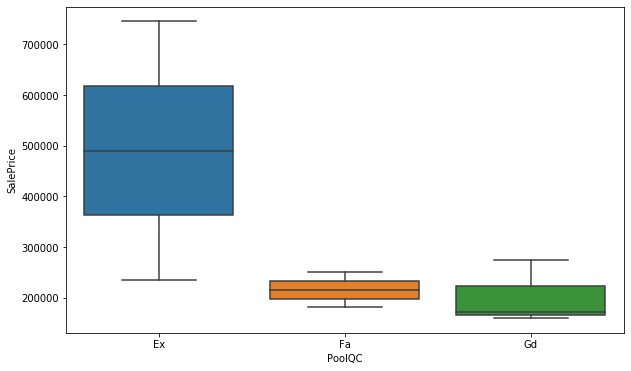

In [13]:
feat = df_train['PoolQC']
f, ax = plt.subplots(figsize=(10,6))
sns.boxplot(y=y_train, x=feat)
plt.show()

In [14]:
df_train['PoolQC'] = df_train['PoolQC'].fillna('None')

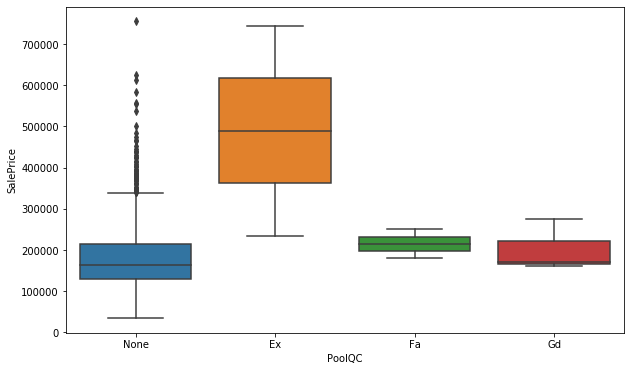

In [15]:
feat = df_train['PoolQC']
f, ax = plt.subplots(figsize=(10,6))
sns.boxplot(y=y_train, x=feat)
plt.show()

we can see from the box plot above that None is actually a usefull feature 

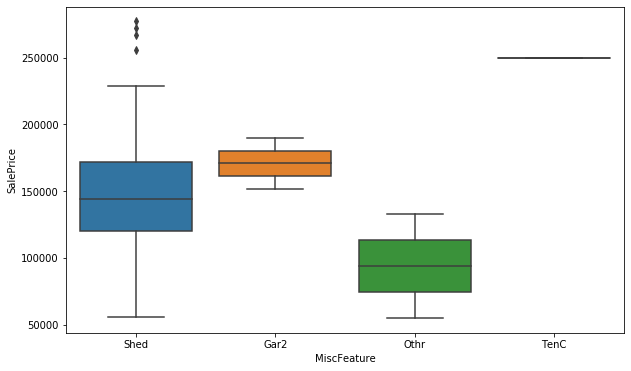

In [16]:
feat = df_train['MiscFeature']
f, ax = plt.subplots(figsize=(10,6))
sns.boxplot(y=y_train, x=feat)
plt.show()

In [17]:
df_train['MiscFeature'] = df_train['MiscFeature'].fillna('None')

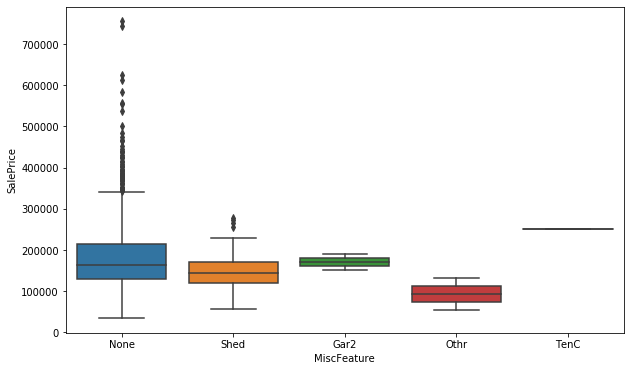

In [18]:
feat = df_train['MiscFeature']
f, ax = plt.subplots(figsize=(10,6))
sns.boxplot(y=y_train, x=feat)
plt.show()

Not very usefull - Remove feature

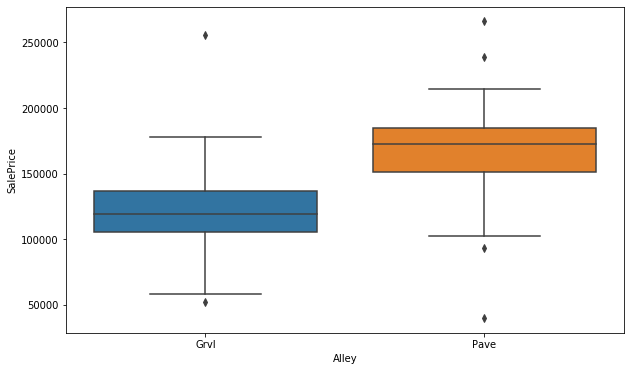

In [19]:
feat = df_train['Alley']
f, ax = plt.subplots(figsize=(10,6))
sns.boxplot(y=y_train, x=feat)
plt.show()

In [20]:
df_train['Alley'] = df_train['Alley'].fillna('None')

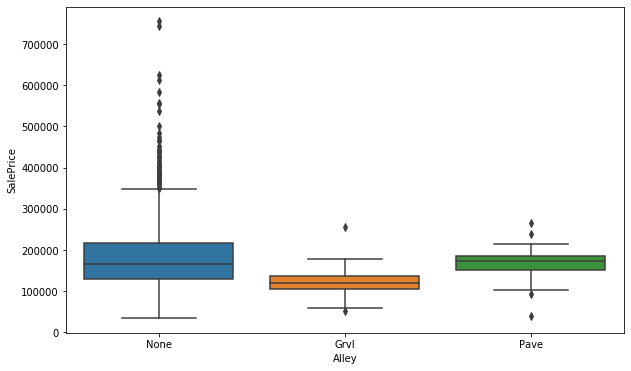

In [21]:
feat = df_train['Alley']
f, ax = plt.subplots(figsize=(10,6))
sns.boxplot(y=y_train, x=feat)
plt.show()

Remove feature 

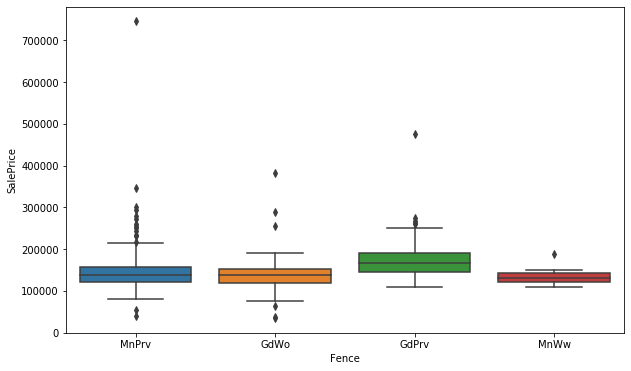

In [22]:
feat = df_train['Fence']
f, ax = plt.subplots(figsize=(10,6))
sns.boxplot(y=y_train, x=feat)
plt.show()

In [23]:
df_train['Fence'] = df_train['Fence'].fillna('None')

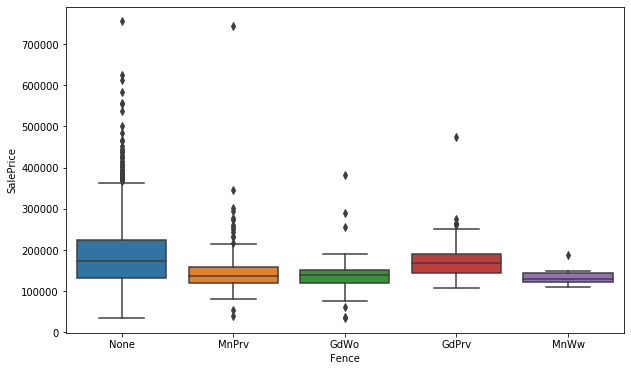

In [24]:
feat = df_train['Fence']
f, ax = plt.subplots(figsize=(10,6))
sns.boxplot(y=y_train, x=feat)
plt.show()

Remove - not a very useful feature

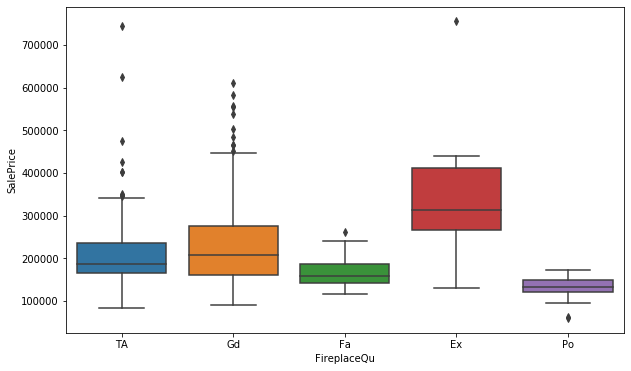

In [25]:
feat = df_train['FireplaceQu']
f, ax = plt.subplots(figsize=(10,6))
sns.boxplot(y=y_train, x=feat)
plt.show()

In [26]:
df_train['FireplaceQu'] = df_train['FireplaceQu'].fillna('None')

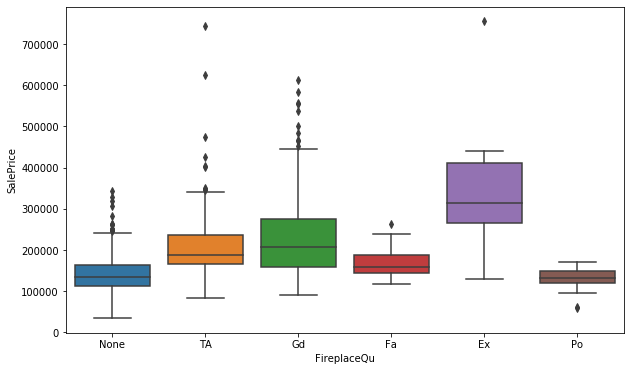

In [27]:
feat = df_train['FireplaceQu']
f, ax = plt.subplots(figsize=(10,6))
sns.boxplot(y=y_train, x=feat)
plt.show()

This is usefull so we will keep this feature 

#### <span style="color:red"> Conclusion</span>
 <span style="color:red">Looking at the features with a high percentage of missing values: PoolQC (keep), MiscFeature (remove), Alley (remove) Fence (remove), FireplaceQu (keep)</span>
 
 <span style="color:red">The remaining categorical features with missing values(mainly garage and basement features) will also be replaced by 'None'. In this case of this data, missing categorical values more than likely indicate that this feature is not present making this a valid substitute. </span>



In [28]:
df_train.select_dtypes(include='object').isna().sum().sort_values(ascending=False).head(12)

GarageType      81
GarageCond      81
GarageQual      81
GarageFinish    81
BsmtExposure    38
BsmtFinType2    38
BsmtQual        37
BsmtCond        37
BsmtFinType1    37
MasVnrType       8
Electrical       1
Utilities        0
dtype: int64

## (3) Data Preprocessing

The conclusions determined in the exploratory analysis section can now be implemented. These changes should theoritically improve our models performance, however if possible it is a good idea to empirically verify each change in case there is some non-linear relationship we are unaware of at play.

In [29]:
X_train = df_train.copy()

(A) Remove numerical features not corelated to the target variable

In [30]:
non_cor_features = [ 'MoSold', 'MiscVal', 'YrSold', 'MSSubClass']

X_train.drop(non_cor_features, axis=1, inplace=True)

(B) Remove features displaying multicollinearity

In [31]:
multi_feats_to_remove = ['GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd']

X_train.drop(multi_feats_to_remove, axis=1, inplace=True)

(C) Remove outliers

 LotFrontage > 200 , LotArea > 100,000 , BsmtFinSF1 > 3000, BsmtFinSF2 > 1300, TotalBsmtSF > 4000, 1stFlrSF > 4000 , GrLivArea > 4000 & SalePrice<30,000

In [32]:
X_train.shape

(1460, 73)

In [33]:
X_train.drop(X_train['LotFrontage'][X_train['LotFrontage']>200].index, inplace=True)
X_train.drop(X_train['LotArea'][X_train['LotArea']>100000].index, inplace=True)
X_train.drop(X_train['BsmtFinSF1'][X_train['BsmtFinSF1']>1300].index, inplace=True)
X_train.drop(X_train['TotalBsmtSF'][X_train['TotalBsmtSF']>4000].index, inplace=True)
X_train.drop(X_train['1stFlrSF'][X_train['1stFlrSF']>4000].index, inplace=True)
X_train.drop(X_train.GrLivArea[(X_train['GrLivArea']>4000) & (y_train<300000)].index, inplace=True)

In [34]:
X_train.shape

(1394, 73)

(D) Handle Missing Values

In [35]:
# Numerical Features
X_train.MasVnrArea = X_train.MasVnrArea.fillna(0)
X_train.LotFrontage = X_train.LotFrontage.fillna(X_train.LotFrontage.mean())

# Categorical Features
none_feats = ['Fence','MiscFeature','Alley','PoolQC', 'FireplaceQu','GarageCond', 'GarageQual', 'GarageFinish',
              'GarageType','BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual',
              'BsmtCond','MasVnrType']

for feature in none_feats:
    X_train[feature] = X_train[feature].fillna("None")

In [36]:
X_train.isna().sum().sort_values(ascending=False).head(12)

Electrical      1
SalePrice       0
ExterCond       0
RoofMatl        0
Exterior1st     0
Exterior2nd     0
MasVnrType      0
MasVnrArea      0
ExterQual       0
Foundation      0
YearRemodAdd    0
BsmtQual        0
dtype: int64

(E) Log transform some numerical variables

For regression models, reducing the skew of the dataset can help improve performance. After investigation, taking the log transform of the target variable 'SalePrice' has notebly reduced skew and improved predictions. Feature columns 'LotArea', '1stFlrSF' and 'GrLivArea' are also log transformed to the same effect. 

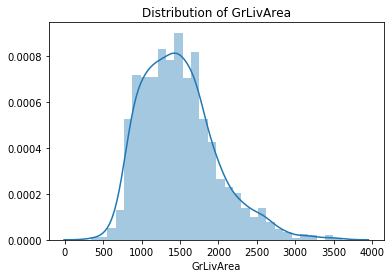

In [37]:
plt.figure()
sns.distplot(X_train.GrLivArea)
plt.title('Distribution of GrLivArea')
plt.show()

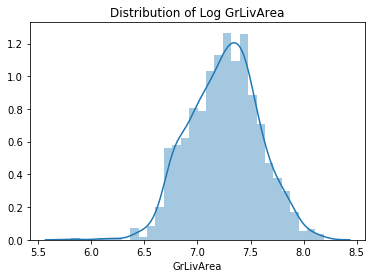

In [38]:
plt.figure()
sns.distplot(np.log(X_train.GrLivArea))
plt.title('Distribution of Log GrLivArea')
plt.show()

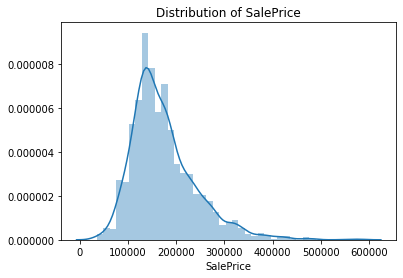

In [39]:
plt.figure()
sns.distplot(X_train.SalePrice)
plt.title('Distribution of SalePrice')
plt.show()

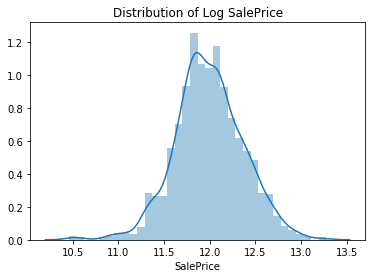

In [40]:
plt.figure()
sns.distplot(np.log(X_train.SalePrice))
plt.title('Distribution of Log SalePrice')
plt.show()

In [41]:
# Include Log transforms
#X_train['LotFrontage'] = np.log(X_train['LotFrontage'])    no 
X_train['LotArea'] = np.log(X_train['LotArea'])              
X_train['1stFlrSF'] = np.log(X_train['1stFlrSF'])         
X_train['GrLivArea'] = np.log(X_train['GrLivArea'])        


Remove the target variable

In [42]:
y_train = np.log(X_train.SalePrice)
X_train.drop(['SalePrice'], axis=1, inplace=True)

(E) Encode categorical features (one hot encoding)

In [43]:
X = X_train.copy()
X = pd.get_dummies(X)

##  (3) Build and verify model

In [44]:
# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y_train, random_state=1)


# Final imputation of missing data - to address any of those outstanding after previous section
my_imputer = SimpleImputer()
train_X = my_imputer.fit_transform(train_X)
val_X = my_imputer.transform(val_X)

Random Forest Model

In [45]:
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(np.exp(rf_val_predictions), np.exp(val_y))
rf_val_mae

C:\Users\ronan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


16533.735781165757

XG Boost Model

In [46]:
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model.fit(train_X, train_y)
xgb_val_predictions = xgb_model.predict(val_X)
xgb_val_mae = mean_absolute_error(np.exp(xgb_val_predictions), np.exp(val_y))
xgb_val_mae

13450.974704512904

Lasso Model

In [47]:
lasso_model = Lasso(alpha=0.0004,random_state=2)
lasso_model.fit(train_X, train_y)
lasso_val_predictions = lasso_model.predict(val_X)
lasso_val_mae = mean_absolute_error(np.exp(lasso_val_predictions), np.exp(val_y))
lasso_val_mae

12459.836418280296

##  (4) Tune model hyperparameters

In [48]:
# fit to full training dataset
imputer = SimpleImputer()
imputed_X = imputer.fit_transform(X)

In [49]:
# Grid search for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Tuning Lasso - This particular model does not have many parameters to tune
param_grid = [{'alpha': [0.0007, 0.0005, 0.0004, 0.0003]}]

# -------------------------------------------------------
grid_search = GridSearchCV(Lasso(), param_grid, cv=5, 
                           scoring='neg_mean_absolute_error')

grid_search.fit(imputed_X, y_train)

grid_search.best_params_

{'alpha': 0.0004}

##  (5) Predict Scores on test dataset

Read in test dataset

In [50]:
test_data = pd.read_csv('test.csv', index_col='Id')
test_X = test_data.copy()
test_indexes = list(test_data.index)

Perform necessary preoprocessing

In [51]:
test_X.drop(non_cor_features, axis=1, inplace=True)
test_X.drop(multi_feats_to_remove, axis=1, inplace=True)

test_X.MasVnrArea = test_X.MasVnrArea.fillna(0)
test_X.LotFrontage = test_X.LotFrontage.fillna(test_X.LotFrontage.mean())


for feature in none_feats:
    test_X[feature] = test_X[feature].fillna("None")
    
test_X['LotArea'] = np.log(test_X['LotArea'])
test_X['1stFlrSF'] = np.log(test_X['1stFlrSF'])         
test_X['GrLivArea'] = np.log(test_X['GrLivArea']) 

In [52]:
# One-hot encoding for categorical data
test_X = pd.get_dummies(test_X)

final_train, final_test = X.align(test_X, join='left', axis=1)

final_test_imputed = my_imputer.transform(final_test)

Build final model with best hyperparameters

In [53]:
final_model = Lasso(alpha=0.0004,random_state=2)

final_train_imputed = my_imputer.fit_transform(final_train)

final_model.fit(final_train_imputed, y_train)

Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=2,
      selection='cyclic', tol=0.0001, warm_start=False)

Make test set predictions

In [54]:
# make predictions which we will submit. 
test_preds = final_model.predict(final_test_imputed)

In [55]:
final_df = pd.DataFrame({'Id':test_indexes, 'SalePrice':list(np.exp(test_preds))})

In [56]:
final_df

,Id,SalePrice
0,1461,117664.011670
1,1462,160152.726695
2,1463,183627.601819
3,1464,204487.534146
4,1465,194479.614386
...,...,...
1454,2915,88341.961647
1455,2916,80937.224176
1456,2917,172044.077760
1457,2918,117619.907304


In [57]:
final_df.to_csv('Lasso_Regression_Predictions.csv', index=False)